### Convolutional Neural Network (CNN) to identify images of Cats v. Dogs

The goal of this project is to use a CNN on Google Colab (because I need access to an Nvidia GPU) to train a model that can correctly identify a dog versus a cat. This project is mostly a challenge since dogs and cats are small furry animals and CNNs typically struggle with such close categories. I also wanted to further explore using GPU computing. 

Overall, the modeling performed here can be expanded out into a variety of computer vision areas. For example, CNNs have been used to quickly detect if a cell is infected with malaria. 

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from IPython.display import display, HTML, Markdown, Latex
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
    
}
div.output_subarea{
    max-width:1200px;
}
div.text_cell_render{
padding: 5em 5em 0.5em 0.5em
}

</style>
"""))

In [7]:
from matplotlib.image import imread

In [8]:
os.listdir('dataset/')

['.DS_Store', 'training_set', 'test_set']

### Images vary in dimensions. This will have to be fixed.

In [20]:
print("Image 1:",imread('dataset/training_set/cats/cat.2.jpg').shape)
print("Image 2:",imread('dataset/training_set/cats/cat.1.jpg').shape)
cat1 = imread('dataset/training_set/cats/cat.1.jpg')
dog1 = imread('dataset/training_set/dogs/dog.1.jpg')

Image 1: (396, 312, 3)
Image 2: (280, 300, 3)


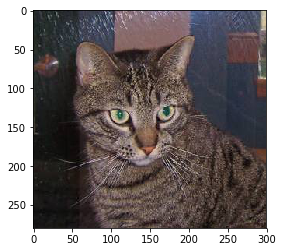

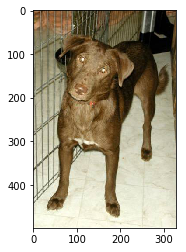

In [21]:
plt.imshow(cat1)
plt.show()
plt.imshow(dog1)
plt.show()

### The training set has 4,000 dog and cat images each

In [25]:
print("Number of cat images:", len(os.listdir('dataset/training_set/cats/')))
print("Number of dog images:", len(os.listdir('dataset/training_set/dogs/')))


Number of cat images: 4000
Number of dog images: 4000


### The average number of dimensions for a cat image appears to be 400 by 500

<Figure size 720x432 with 0 Axes>

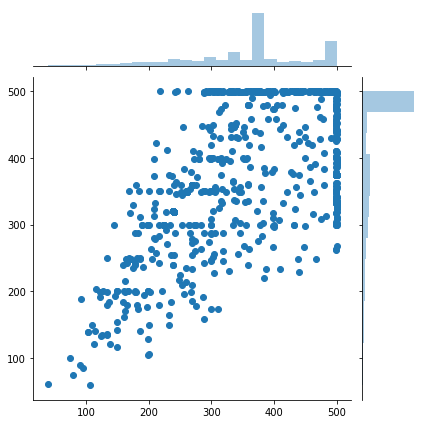

In [37]:
dim1 = []
dim2 = []

for image in os.listdir('dataset/test_set/cats/'):
    img  = imread('dataset/test_set/cats/'+image)
    d1,d2,color = img.shape
    
    dim1.append(d1)
    dim2.append(d2)
    
plt.figure(figsize=[10,6])
sns.jointplot(dim1, dim2)
plt.show()

### The average number of dimensions for a dog image appears to be about 450 by 500

<Figure size 720x432 with 0 Axes>

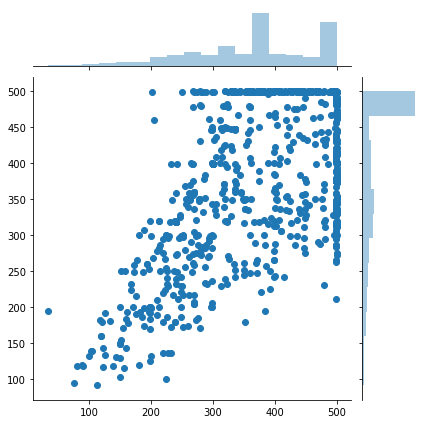

In [35]:
dim1 = []
dim2 = []

for image in os.listdir('dataset/test_set/dogs/'):
    img  = imread('dataset/test_set/dogs/'+image)
    d1,d2,color = img.shape
    
    dim1.append(d1)
    dim2.append(d2)
    
plt.figure(figsize=[10,6])
sns.jointplot(dim1, dim2)
plt.show()

In [41]:
print(f"The median of dim1 is {np.median(dim1)}")
print(f"The median of dim2 is {np.median(dim2)}")

The median of dim1 is 374.0
The median of dim2 is 480.0


### Based on the median dimensions, I will rescale all the images to be 380 by 480

In [42]:
image_shape = (380, 480, 3)

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### So as to keep the CNN robust, I will also randomly deform the images by zooming, flipping, etc.
Note dog from before is horizontally flipped and rotated a bit

In [44]:
image_gen = ImageDataGenerator(rotation_range=10,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              zoom_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest')

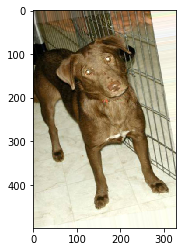

In [46]:
plt.imshow(image_gen.random_transform(dog1))

### Data flow for training set

In [47]:
image_gen.flow_from_directory('dataset/training_set/')

Found 8000 images belonging to 2 classes.


### Data flow for test set

In [48]:
image_gen.flow_from_directory('dataset/test_set/')

Found 2000 images belonging to 2 classes.


### Model

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout

In [51]:
model = Sequential()

model.add(Conv2D(filters=32,
                kernel_size=(3,3),
                input_shape=image_shape,
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                kernel_size=(3,3),
                input_shape=image_shape,
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                kernel_size=(3,3),
                input_shape=image_shape,
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,
                kernel_size=(3,3),
                input_shape=image_shape,
                activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid')) ##b/c binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 378, 478, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 189, 239, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 187, 237, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 93, 118, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 91, 116, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 58, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 56, 64)        3

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

In [53]:
early_stop = EarlyStopping(patience=3)

In [54]:
batch_size = 16

In [55]:
train_image_gen = image_gen.flow_from_directory(directory='dataset/training_set/',
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 8000 images belonging to 2 classes.


In [56]:
test_image_gen = image_gen.flow_from_directory(directory='dataset/test_set/',
                                               target_size=image_shape[:2],##must specify w&h
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',
                                              shuffle=False) ## don't want to shuffle 
## the correct answers around (obviously)

Found 2000 images belonging to 2 classes.


### Cats are coded as 0 and dogs are coded as 1

In [57]:
train_image_gen.class_indices

{'cats': 0, 'dogs': 1}

In [58]:
results = model.fit(train_image_gen,
                   epochs=20,
                   validation_data=test_image_gen,
                   callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 125 steps
Epoch 1/20
 15/500 [..............................] - ETA: 11:16 - loss: 22.2734 - accuracy: 0.5089WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


KeyboardInterrupt: 

In [59]:
pd.DataFrame(model.history.history)[['accuracy', 'val_accuracy']].plot()

KeyError: "['val_accuracy'] not in index"

In [ ]:
pd.DataFrame(model.history.history)[['los', 'val_loss']].plot()